# Dubinska analiza podataka - projektni zadatak

## 1. Predprocesiranje podataka

In [147]:
# Ovo je tu jer ponekad zna prvu liniju u svakoj čeliji označit kao grešku makar sve radi,
# ali me živcira to podcrtano. Pa treba ovo pokrenut, pa se od VS coda izbaci da se treba
# instalirati 'languagepack' pa onda zatvorit i opet otvorit .ipynb file i nema više podcrtanog

# lintr::use_lintr(type = "tidyverse")

In [5]:
#install.packages('neuralnet')
#install.packages('randomForest')
#install.packages('factoextra')
#install.packages("arules")
#install.packages("arulesViz")

library(tidyr)
library(dplyr)
library(caret)
library(neuralnet)
library(randomForest)
library(factoextra)
library(arules)
library(arulesViz)
library(reshape2)
library(cluster)


Attaching package: 'tidyr'


The following object is masked from 'package:reshape2':

    smiths


The following objects are masked from 'package:Matrix':

    expand, pack, unpack




In [6]:
# Importing data and displaying the internal structure
phoneData <- read.csv('phone_specs.csv')

str(phoneData)

'data.frame':	1359 obs. of  22 variables:
 $ Index          : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Name           : chr  "OnePlus 7T Pro McLaren Edition" "Realme X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ Brand          : chr  "OnePlus" "Realme" "Apple" "Apple" ...
 $ Model          : chr  "7T Pro McLaren Edition" "X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ BatteryCapacity: int  4085 4000 3969 3110 4000 3800 4085 4300 6000 4000 ...
 $ ScreenSize     : num  6.67 6.5 6.5 6.1 6.4 6.55 6.67 6.8 6.59 6.39 ...
 $ Touchscreen    : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ ResolutionX    : int  1440 1080 1242 828 1080 1080 1440 1440 1080 1080 ...
 $ ResolutionY    : int  3120 2400 2688 1792 2340 2400 3120 3040 2340 2340 ...
 $ Processor      : int  8 8 6 6 8 8 8 8 8 8 ...
 $ RAM            : int  12000 6000 4000 4000 6000 8000 8000 12000 8000 6000 ...
 $ InternalStorage: num  256 64 64 64 128 128 256 256 128 128 ...
 $ RearCamera     : num  48 64 12 12 12 48 48 12 48 48 ...
 $ FrontCamera    : nu

In [7]:
# OS data with name and frequency 
table(phoneData$OS)


   Android BlackBerry   Cyanogen        iOS   Sailfish      Tizen    Windows 
      1299         10         10         17          1          3         19 

In [8]:
phoneData <- phoneData %>%
    filter(!(OS == 'Sailfish' | OS == 'Tizen')) %>%                       # delete rows with less know OS (only 3 rows) because One-hot-encoding
    mutate(value = 1) %>% spread(OS, value,  fill = 0 ) %>%               # One-hot-encoding OS column
    mutate(Price = round(Price / 87.95)) %>%                              # convert price (indian rupee to euro)
    mutate(PriceCategory = ifelse(Price <= 200, 'Low-End',
                           ifelse(Price <= 500, 'Mid-Range', 'High-End'))) %>%      # Defining price categories
    filter(!(PriceCategory == 'Low-End' & RearCamera >= 20)) %>%
    filter(!(PriceCategory == 'Low-End' & FrontCamera >= 10)) %>%
    filter(!(PriceCategory == 'Low-End' & RAM > 4000)) %>%
    filter(!(PriceCategory == 'Low-End' & InternalStorage > 64))          # Filtering some data to get better accuracy

In [9]:
names(phoneData)

[1] "Index"           "Name"            "Brand"           "Model"          
 [5] "BatteryCapacity" "ScreenSize"      "Touchscreen"     "ResolutionX"    
 [9] "ResolutionY"     "Processor"       "RAM"             "InternalStorage"
[13] "RearCamera"      "FrontCamera"     "WiFi"            "Bluetooth"      
[17] "GPS"             "SIMsNumber"      "X3G"             "X4G.LTE"        
[21] "Price"           "Android"         "BlackBerry"      "Cyanogen"       
[25] "iOS"             "Windows"         "PriceCategory"

In [10]:
# Removing columns that are not used for traning (Index, Name, Brand, Model and Price)
phoneData <- phoneData[-c(1:4, 21)]

In [11]:
table(phoneData$PriceCategory)


 High-End   Low-End Mid-Range 
       49       977       144 

## 2. Klasifikacija - umjetne neuronske mreže

In [12]:
# Neuralnet requires normalized data and accepts only numerical values as input
phoneData_nn <- phoneData %>%
    mutate(across(c(Touchscreen, WiFi, Bluetooth, GPS, X3G, X4G.LTE), ~as.numeric(ifelse(.x == 'Yes', 1, 0)))) %>%    # convert categorical Yes/No to 1/0 
    mutate(across(c(1:2, 4:10, 14), scale))                                                                           # normalization with scale() for numeric data

#### Prvi ANN model --> nauralnet paket

In [13]:
# First ANN model with neuralnet package
set.seed(123)

trainIndex = createDataPartition(phoneData_nn$PriceCategory, p = 0.75, list = FALSE)
trainData <- phoneData_nn[trainIndex, ]
testData <- phoneData_nn[-trainIndex, ] 

nn = neuralnet(PriceCategory ~ .,
                data = trainData,
                hidden = 14,
                lifesign = 'full',
                linear.output = FALSE)

hidden: 14    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.0996231409036611
                                                 
   2000	min thresh: 0.0546513793901923
                                                 
   3000	min thresh: 0.0253587093223993
                                                 
   4000	min thresh: 0.0108831842964161
                                                 
   4092
	error: 14.20329
	time: 15.38 secs



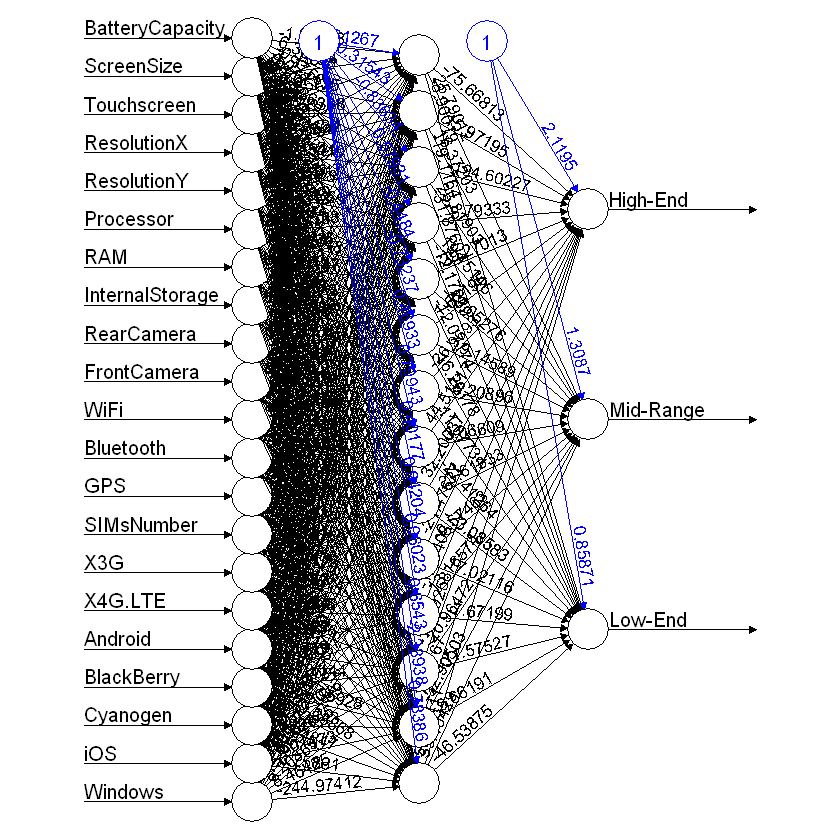

In [14]:
plot(nn, rep=1)

In [15]:
predictions <- neuralnet::compute(nn, rep = 1, testData[, -23])

pred <- predictions$net.result

pred <- data.frame("pred" = ifelse(max.col(pred[ ,1:3]) == 1, 'High-End',
                            ifelse(max.col(pred[ ,1:3]) == 2, 'Low-End', 'Mid-Range')))

cm <- confusionMatrix(as.factor(testData$PriceCategory), as.factor(pred$pred))
 
print(cm)

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         6       2         4
  Low-End          0     240         4
  Mid-Range        8       8        20

Overall Statistics
                                         
               Accuracy : 0.911          
                 95% CI : (0.8723, 0.941)
    No Information Rate : 0.8562         
    P-Value [Acc > NIR] : 0.003237       
                                         
                  Kappa : 0.6712         
                                         
 Mcnemar's Test P-Value : 0.197897       

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.42857         0.9600          0.71429
Specificity                  0.97842         0.9048          0.93939
Pos Pred Value               0.50000         0.9836          0.55556
Neg Pred Value               0.97143         0.7917          0.96875
Prevalence              

#### Drugi ANN model --> train(method='nnet')

In [19]:
# Second ANN model with train() function
set.seed(1)

train_index <- createFolds(trainData$PriceCategory, k = 10)

nnetFit <- phoneData_nn %>% train(PriceCategory ~ .,
    method = 'nnet',
    data = .,
    tuneLength = 5,
    trControl = trainControl(method = 'cv', indexOut = train_index),
    trace = FALSE)

nnetFit

Neural Network 

1170 samples
  21 predictor
   3 classes: 'High-End', 'Low-End', 'Mid-Range' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1052, 1052, 1053, 1054, 1054, 1052, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa    
  1     0e+00  0.8884726  0.6709041
  1     1e-04  0.8760237  0.5611517
  1     1e-03  0.8792644  0.6254778
  1     1e-02  0.8781536  0.6244270
  1     1e-01  0.8792899  0.6195292
  3     0e+00  0.9007929  0.7061318
  3     1e-04  0.9078186  0.7347591
  3     1e-03  0.9111627  0.7375155
  3     1e-02  0.9156699  0.7424988
  3     1e-01  0.9133847  0.7329313
  5     0e+00  0.9396905  0.8014908
  5     1e-04  0.9339306  0.8019521
  5     1e-03  0.9282880  0.7814341
  5     1e-02  0.9407497  0.8236120
  5     1e-01  0.9339571  0.7997686
  7     0e+00  0.9373537  0.8034415
  7     1e-04  0.9396775  0.8214573
  7     1e-03  0.9519973  0.8587739
  7     1e-02  0.9441852  0.8330079
  7     1e-01  

In [20]:
pr <- predict(nnetFit, testData)
confusionMatrix(pr, as.factor(testData$PriceCategory))

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         9       0         2
  Low-End          2     242         2
  Mid-Range        1       2        32

Overall Statistics
                                          
               Accuracy : 0.9692          
                 95% CI : (0.9423, 0.9858)
    No Information Rate : 0.8356          
    P-Value [Acc > NIR] : 3.31e-13        
                                          
                  Kappa : 0.8898          
                                          
 Mcnemar's Test P-Value : 0.5062          

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.75000         0.9918           0.8889
Specificity                  0.99286         0.9167           0.9883
Pos Pred Value               0.81818         0.9837           0.9143
Neg Pred Value               0.98932         0.9565           0.9844
Prevalence     

## 3. Ansambli - slučajne šume

In [21]:
# Random forest only recive numerical and logical data as the input
# so we convert categorical data to logical TRUE/FALSE

phoneData_rf <- phoneData %>%
    mutate(across(c(Touchscreen, WiFi, Bluetooth, GPS, X3G, X4G.LTE), ~as.logical(ifelse(.x == 'Yes', TRUE, FALSE))))

#### Prvi model slučajnih šuma --> train(method='rf')

In [23]:
set.seed(1)

trainIndex = createDataPartition(phoneData_rf$PriceCategory, p = 0.75, list = FALSE)
trainData <- phoneData_rf[trainIndex, ]
testData <- phoneData_rf[-trainIndex, ]

train_index <- createFolds(trainData$PriceCategory, k = 10)

rf_model1 <- trainData %>% train(PriceCategory ~ .,
    method = 'rf',
    data = .,
    tuneLength = 5,
    trControl = trainControl(method = 'cv', indexOut = train_index))

rf_model1

Random Forest 

878 samples
 21 predictor
  3 classes: 'High-End', 'Low-End', 'Mid-Range' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 789, 790, 791, 790, 789, 791, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9420268  0.7679104
   6    0.9908948  0.9678357
  11    0.9897454  0.9636043
  16    0.9885960  0.9597307
  21    0.9897196  0.9635986

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.

In [24]:
prediction_rf1 <- predict(rf_model1, testData)
confusionMatrix(prediction_rf1, as.factor(testData$PriceCategory))

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         5       0         5
  Low-End          0     239         6
  Mid-Range        7       5        25

Overall Statistics
                                          
               Accuracy : 0.9212          
                 95% CI : (0.8842, 0.9494)
    No Information Rate : 0.8356          
    P-Value [Acc > NIR] : 1.335e-05       
                                          
                  Kappa : 0.7205          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.41667         0.9795          0.69444
Specificity                  0.98214         0.8750          0.95312
Pos Pred Value               0.50000         0.9755          0.67568
Neg Pred Value               0.97518         0.8936          0.95686
Prevalence     

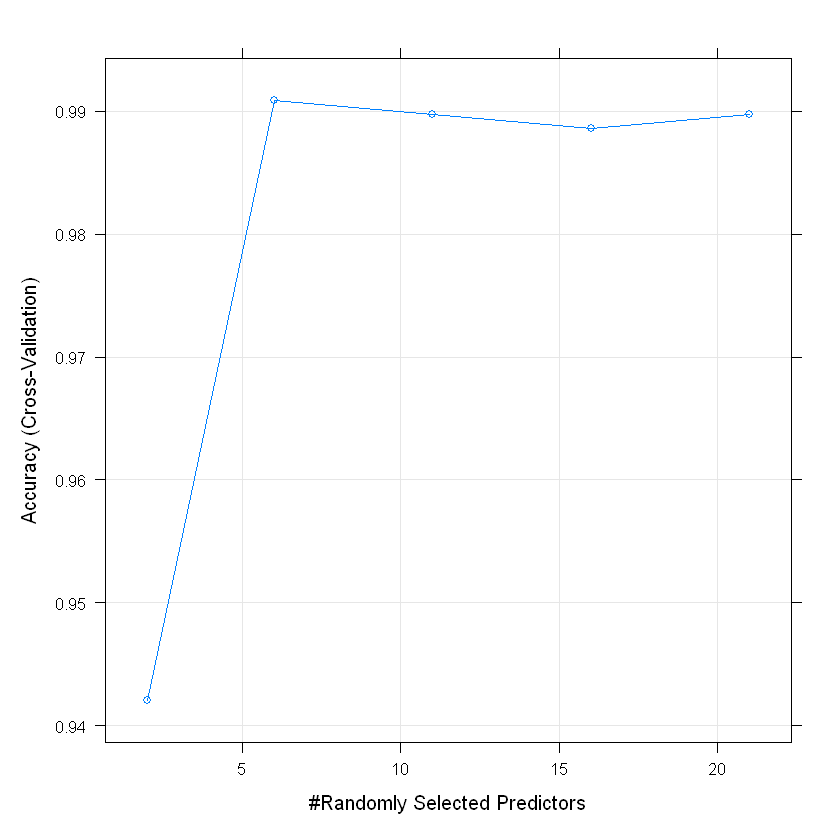

In [25]:
plot(rf_model1)

#### Drugi model slučajnih šuma --> randomForest paket

In [26]:
rf_model2 <- randomForest(x = trainData[-22], y = as.factor(trainData$PriceCategory), ntree = 600)
rf_model2


Call:
 randomForest(x = trainData[-22], y = as.factor(trainData$PriceCategory),      ntree = 600) 
               Type of random forest: classification
                     Number of trees: 600
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.11%
Confusion matrix:
          High-End Low-End Mid-Range class.error
High-End        15       6        16  0.59459459
Low-End          1     719        13  0.01909959
Mid-Range        4      40        64  0.40740741

In [28]:
predictions_rf2 = predict(rf_model2, testData[-22])
  
confusionMatrix(predictions_rf2, as.factor(testData$PriceCategory))

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         5       0         3
  Low-End          1     239         7
  Mid-Range        6       5        26

Overall Statistics
                                          
               Accuracy : 0.9247          
                 95% CI : (0.8882, 0.9522)
    No Information Rate : 0.8356          
    P-Value [Acc > NIR] : 5.596e-06       
                                          
                  Kappa : 0.7274          
                                          
 Mcnemar's Test P-Value : 0.5062          

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.41667         0.9795          0.72222
Specificity                  0.98929         0.8333          0.95703
Pos Pred Value               0.62500         0.9676          0.70270
Neg Pred Value               0.97535         0.8889          0.96078
Prevalence     

,OOB,High-End,Low-End,Mid-Range
"[595,]",0.09111617,0.5945946,0.01909959,0.4074074
"[596,]",0.09111617,0.5945946,0.01909959,0.4074074
"[597,]",0.09111617,0.5945946,0.01909959,0.4074074
"[598,]",0.09111617,0.5945946,0.01909959,0.4074074
"[599,]",0.09111617,0.5945946,0.01909959,0.4074074
"[600,]",0.09111617,0.5945946,0.01909959,0.4074074


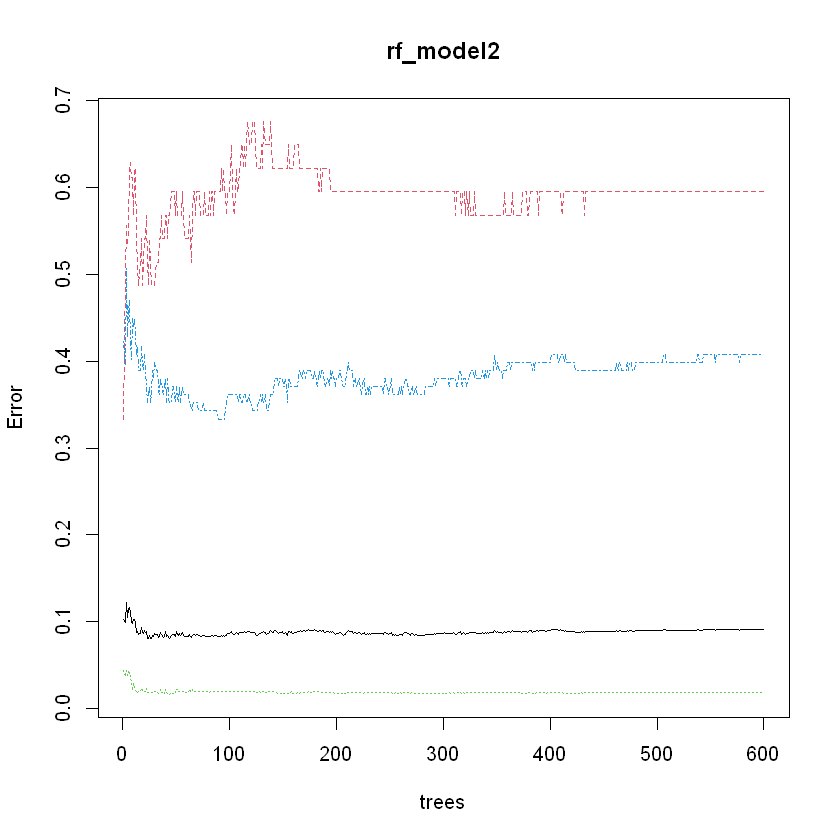

In [29]:
tail(plot(rf_model2))

In [31]:
importance(rf_model2)

,MeanDecreaseGini
BatteryCapacity,17.29254539
ScreenSize,18.82166079
Touchscreen,0.01221481
ResolutionX,22.09925061
ResolutionY,37.87593893
Processor,7.52750376
RAM,22.66039198
InternalStorage,22.46578499
RearCamera,23.74243767
FrontCamera,31.72353186


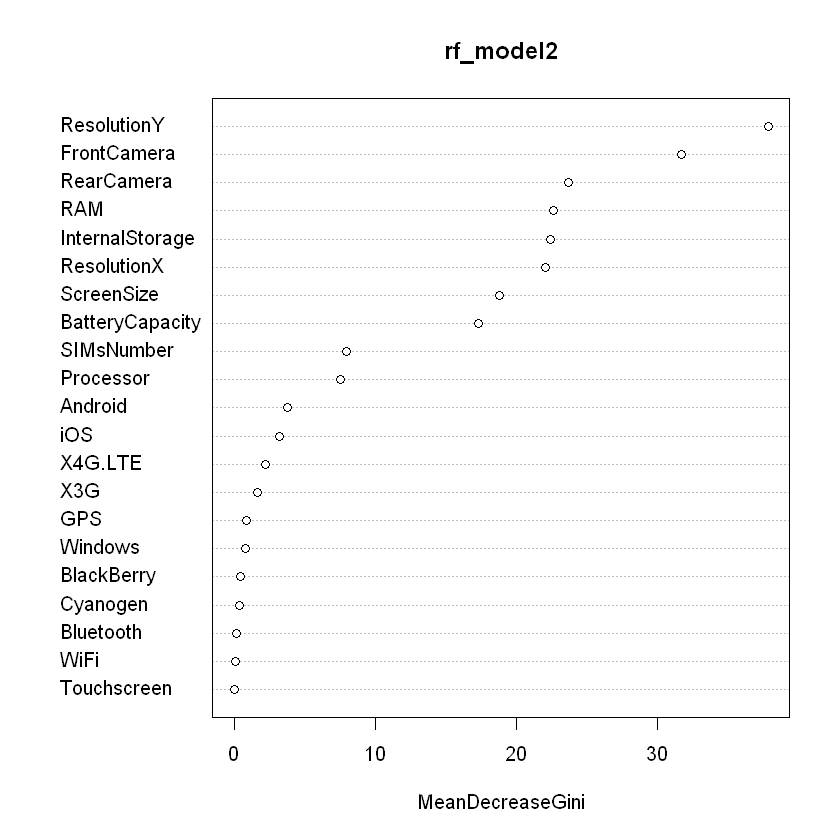

In [32]:
varImpPlot(rf_model2)

## 4. Asocijacijska analiza - učenje asocijacijskih pravila

In [33]:
phoneData3 <- read.csv('phone_specs.csv')
ijdskj

names(phoneData3)

[1] "Index"           "Name"            "Brand"           "Model"          
 [5] "BatteryCapacity" "ScreenSize"      "Touchscreen"     "ResolutionX"    
 [9] "ResolutionY"     "Processor"       "RAM"             "InternalStorage"
[13] "RearCamera"      "FrontCamera"     "OS"              "WiFi"           
[17] "Bluetooth"       "GPS"             "SIMsNumber"      "X3G"            
[21] "X4G.LTE"         "Price"

In [34]:
phoneData_ar <- phoneData3 %>%
    filter(RAM >= 1000) %>%
    mutate(across(c(OS, SIMsNumber, RAM, InternalStorage), as.factor)) %>%
    mutate(BatteryCapacity = discretize(BatteryCapacity, method = "fixed",
                                        breaks = c(1000, 2000, 3000, 4000, 5000, 6000),
                                        labels = c("[1000,2000)", "[2000,3000)", "[3000,4000)", "[4000,5000)", "[5000,6000)"))) %>%
    mutate(RearCamera = discretize(RearCamera, method = "fixed",
                                        breaks = c(0, 10, 20, 40, 108),
                                        labels = c("[0,10)", "[10,20)", "[20,40)", "[40,108)"))) %>%
    mutate(FrontCamera = discretize(FrontCamera, method = "fixed",
                                        breaks = c(0, 10, 20, 48),
                                        labels = c("[0,10)", "[10,20)", "[20,48)")))

In [36]:
row.names(phoneData_ar) <- phoneData_ar$Name
phoneData_ar <- phoneData_ar[-c(1:4, 6:10, 16:22)]
names(phoneData_ar)

[1] "BatteryCapacity" "RAM"             "InternalStorage" "RearCamera"     
[5] "FrontCamera"     "OS"

In [38]:
trans <- transactions(phoneData_ar)
summary(trans)

transactions as itemMatrix in sparse format with
 1273 rows (elements/itemsets/transactions) and
 35 columns (items) and a density of 0.1714286 

most frequent items:
                 OS=Android          FrontCamera=[0,10) 
                       1224                        1028 
         RearCamera=[10,20) BatteryCapacity=[2000,3000) 
                        694                         517 
          RearCamera=[0,10)                     (Other) 
                        484                        3691 

element (itemset/transaction) length distribution:
sizes
   6 
1273 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      6       6       6       6       6       6 

includes extended item information - examples:
                       labels       variables      levels
1 BatteryCapacity=[1000,2000) BatteryCapacity [1000,2000)
2 BatteryCapacity=[2000,3000) BatteryCapacity [2000,3000)
3 BatteryCapacity=[3000,4000) BatteryCapacity [3000,4000)

includes extended transaction information

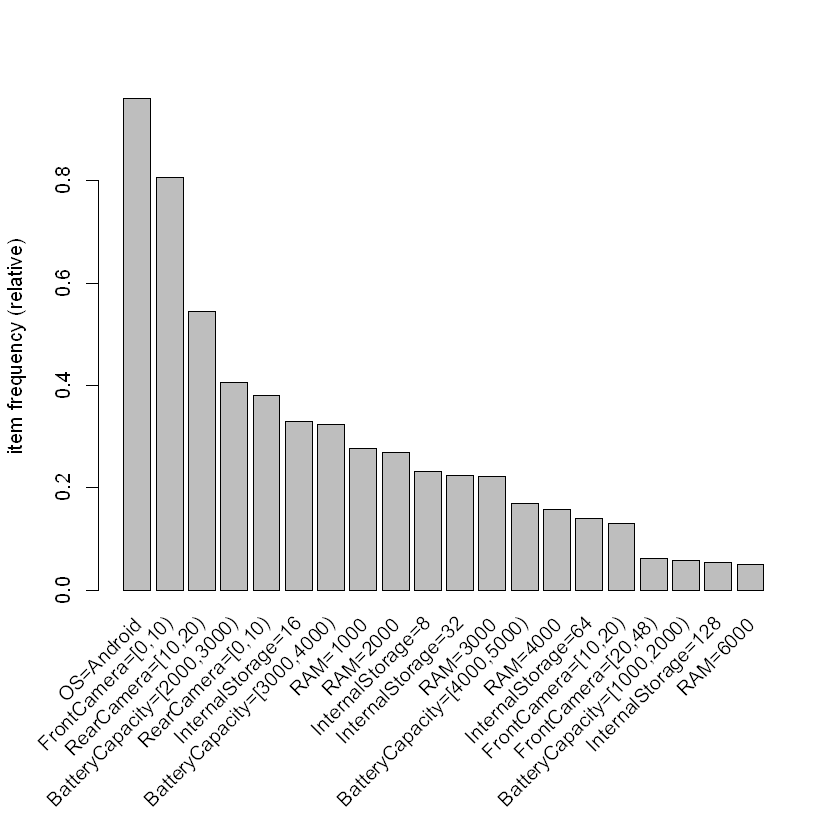

In [41]:
itemFrequencyPlot(trans, topN = 20)

In [42]:
rules <- apriori(trans, parameter = list(support = 0.05, confidence = 0.9))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.9    0.1    1 none FALSE            TRUE       5    0.05      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 63 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[35 item(s), 1273 transaction(s)] done [0.00s].
sorting and recoding items ... [19 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 done [0.00s].
writing ... [282 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [43]:
length(rules)

[1] 282

In [44]:
inspect(rules)

      lhs                               rhs                     support confidence   coverage      lift count
[1]   {}                             => {OS=Android}         0.96150825  0.9615082 1.00000000 1.0000000  1224
[2]   {InternalStorage=128}          => {OS=Android}         0.05420267  1.0000000 0.05420267 1.0400327    69
[3]   {BatteryCapacity=[1000,2000)}  => {RearCamera=[0,10)}  0.05341712  0.9315068 0.05734485 2.4500170    68
[4]   {BatteryCapacity=[1000,2000)}  => {FrontCamera=[0,10)} 0.05734485  1.0000000 0.05734485 1.2383268    73
[5]   {FrontCamera=[20,48)}          => {OS=Android}         0.06205813  1.0000000 0.06205813 1.0400327    79
[6]   {FrontCamera=[10,20)}          => {OS=Android}         0.12804399  0.9819277 0.13040063 1.0212369   163
[7]   {InternalStorage=64}           => {OS=Android}         0.13197172  0.9438202 0.13982718 0.9816039   168
[8]   {RAM=4000}                     => {OS=Android}         0.15161037  0.9650000 0.15710919 1.0036315   193
[9]   {Bat

## 5. Grupiranje k-sredina

In [45]:
phoneData2 <- read.csv('phone_specs.csv')

phoneData_kmeans <- phoneData2 %>%
    mutate(Price = round(Price / 87.95)) %>%
    mutate(PriceCategory = ifelse(Price <= 100, '1',
                            ifelse(Price <= 200, '2', '3'))) %>%
    filter(!(PriceCategory == '1' & (RAM <= 64 | RAM > 1000))) %>%
    filter(!(PriceCategory == '1' & (InternalStorage <= 3 | InternalStorage > 8))) %>%
    filter(!(PriceCategory == '1' & RearCamera > 5)) %>%
    filter(!(PriceCategory == '1' & FrontCamera > 1.3)) %>%
    filter(!(PriceCategory == '2' & (RAM <= 1000 | RAM >= 4000))) %>%
    filter(!(PriceCategory == '2' & (InternalStorage <= 8 | InternalStorage > 32))) %>%
    filter(!(PriceCategory == '2' & (RearCamera <= 5 | RearCamera > 13))) %>%
    filter(!(PriceCategory == '2' & (FrontCamera <= 1.3 | FrontCamera > 5))) %>%
    filter(!(PriceCategory == '3' & RAM < 4000)) %>%
    filter(!(PriceCategory == '3' & (InternalStorage <= 32 | InternalStorage >= 256))) %>%
    filter(!(PriceCategory == '3' & (RearCamera < 13 | RearCamera >= 64))) %>%
    filter(!(PriceCategory == '3' & (FrontCamera < 8 | FrontCamera >= 40)))


In [46]:
table(phoneData_kmeans$PriceCategory)


 1  2  3 
85 71 54 

In [47]:
names(phoneData_kmeans)

[1] "Index"           "Name"            "Brand"           "Model"          
 [5] "BatteryCapacity" "ScreenSize"      "Touchscreen"     "ResolutionX"    
 [9] "ResolutionY"     "Processor"       "RAM"             "InternalStorage"
[13] "RearCamera"      "FrontCamera"     "OS"              "WiFi"           
[17] "Bluetooth"       "GPS"             "SIMsNumber"      "X3G"            
[21] "X4G.LTE"         "Price"           "PriceCategory"

In [48]:
phoneData_kmeans <- phoneData_kmeans[-c(1:10, 15:22)]

names(phoneData_kmeans)

[1] "RAM"             "InternalStorage" "RearCamera"      "FrontCamera"    
[5] "PriceCategory"

In [49]:
phoneData_kmeans <- phoneData_kmeans %>% mutate(across(c(1:4), scale))

In [50]:
phoneData_kmeans$index <- 1:nrow(phoneData_kmeans)
phoneData_kmeans$x <- paste(phoneData_kmeans$index, phoneData_kmeans$PriceCategory)
rownames(phoneData_kmeans) <- phoneData_kmeans$x
phoneData_kmeans <- phoneData_kmeans[-c(6:7)]
head(phoneData_kmeans)

,RAM,InternalStorage,RearCamera,FrontCamera,PriceCategory
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>
1 3,2.360400,2.2399984,2.721428,1.211087,3
2 3,2.360400,2.2399984,2.721428,2.204993,3
3 3,1.477526,2.2399984,2.721428,1.708040,3
4 3,1.477526,0.6916761,0.226204,1.211087,3
5 3,1.477526,0.6916761,2.721428,1.708040,3
6 3,1.477526,2.2399984,2.721428,1.211087,3


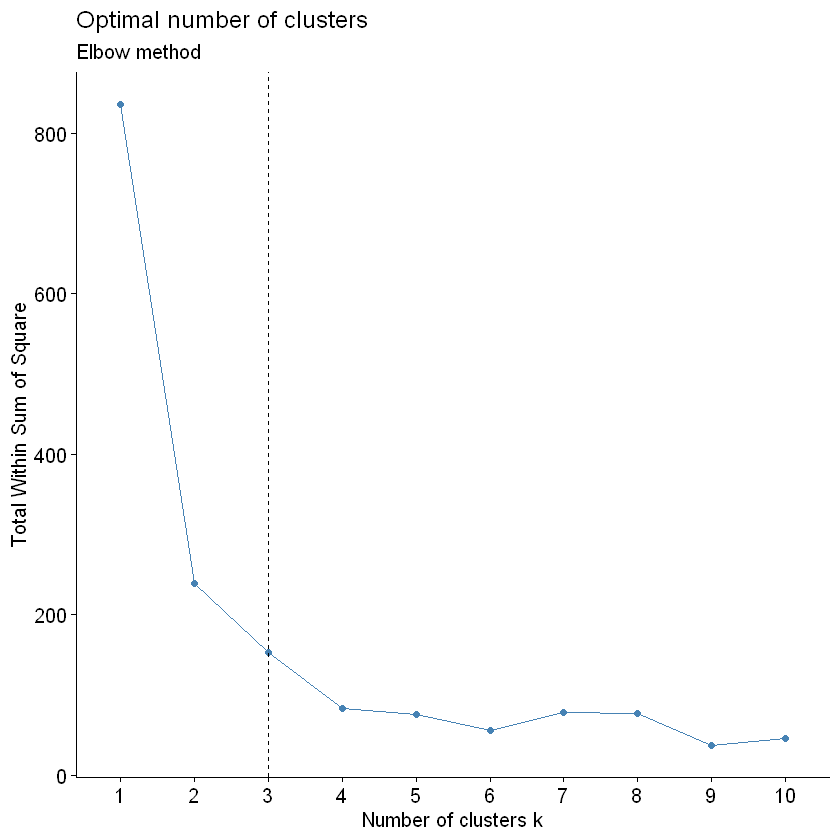

In [51]:
fviz_nbclust(phoneData_kmeans[-5], kmeans, method = "wss") + geom_vline(xintercept = 3, linetype = 2) + labs(subtitle = "Elbow method")

In [52]:
set.seed(240)

kmeans_model <- kmeans(phoneData_kmeans[-5], centers = 3)
kmeans_model

K-means clustering with 3 clusters of sizes 88, 84, 38

Cluster means:
          RAM InternalStorage   RearCamera FrontCamera
1 -0.83945433      -0.6905974 -0.725631971 -0.72335986
2  0.08489878      -0.1239579 -0.009579879 -0.06220788
3  1.75632850       1.8732905  1.701587456  1.81266130

Clustering vector:
  1 3   2 3   3 3   4 3   5 3   6 3   7 3   8 3   9 3  10 3  11 3  12 3  13 3 
    3     3     3     3     3     3     3     3     3     3     3     3     3 
 14 3  15 3  16 3  17 3  18 3  19 3  20 3  21 3  22 3  23 3  24 3  25 3  26 3 
    2     3     3     3     3     3     3     3     3     3     3     3     2 
 27 3  28 3  29 1  30 3  31 2  32 3  33 2  34 2  35 2  36 2  37 2  38 2  39 2 
    3     3     1     2     2     3     2     2     2     2     2     2     2 
 40 2  41 2  42 3  43 3  44 3  45 3  46 3  47 3  48 2  49 3  50 2  51 3  52 2 
    2     2     3     3     3     2     3     3     2     3     2     2     2 
 53 2  54 2  55 3  56 2  57 2  58 2  59 2  60 2  61 2  62

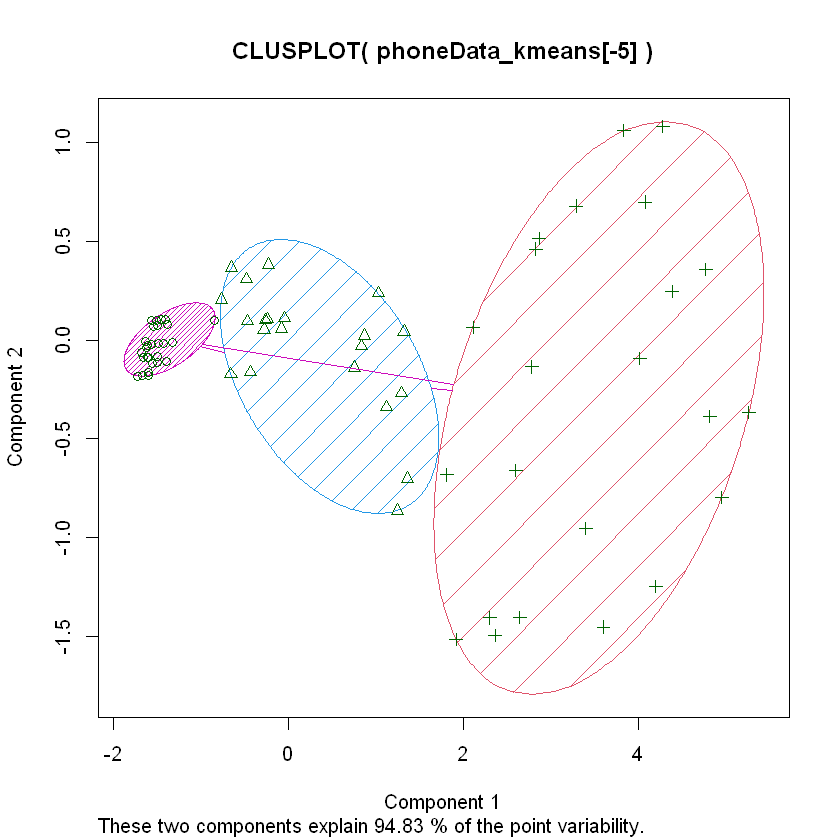

In [53]:
clusplot(phoneData_kmeans[-5], kmeans_model$cluster, color=T, shade=T)

  cluster size ave.sil.width
1       1   88          0.82
2       2   84          0.45
3       3   38          0.38


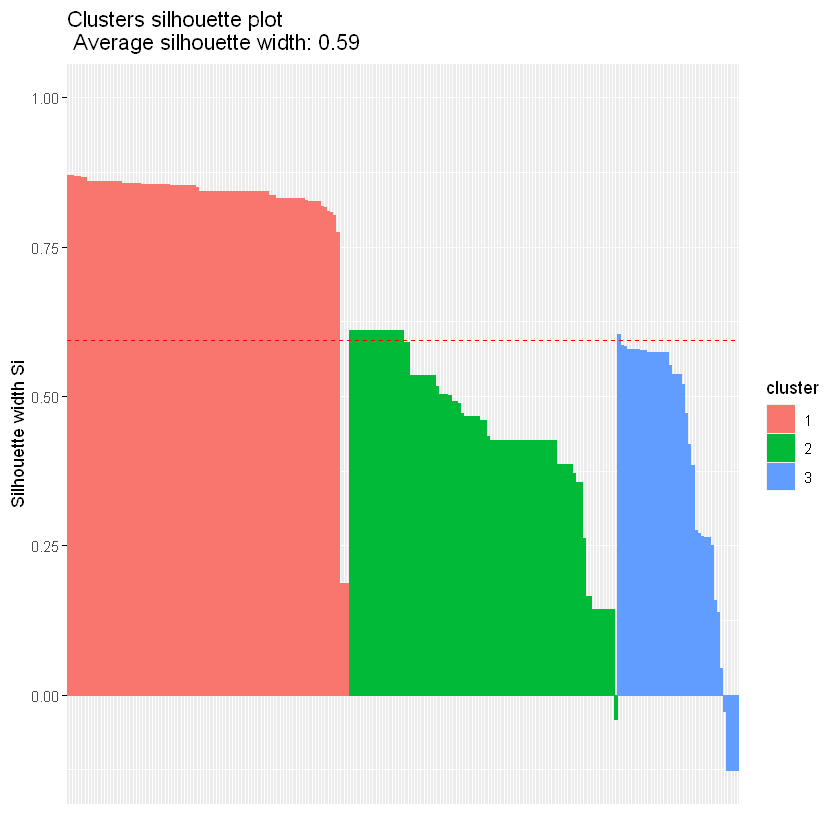

In [54]:
sil <- silhouette(kmeans_model$cluster, dist(phoneData_kmeans[-5]), ordered = FALSE)
fviz_silhouette(sil, label = FALSE)

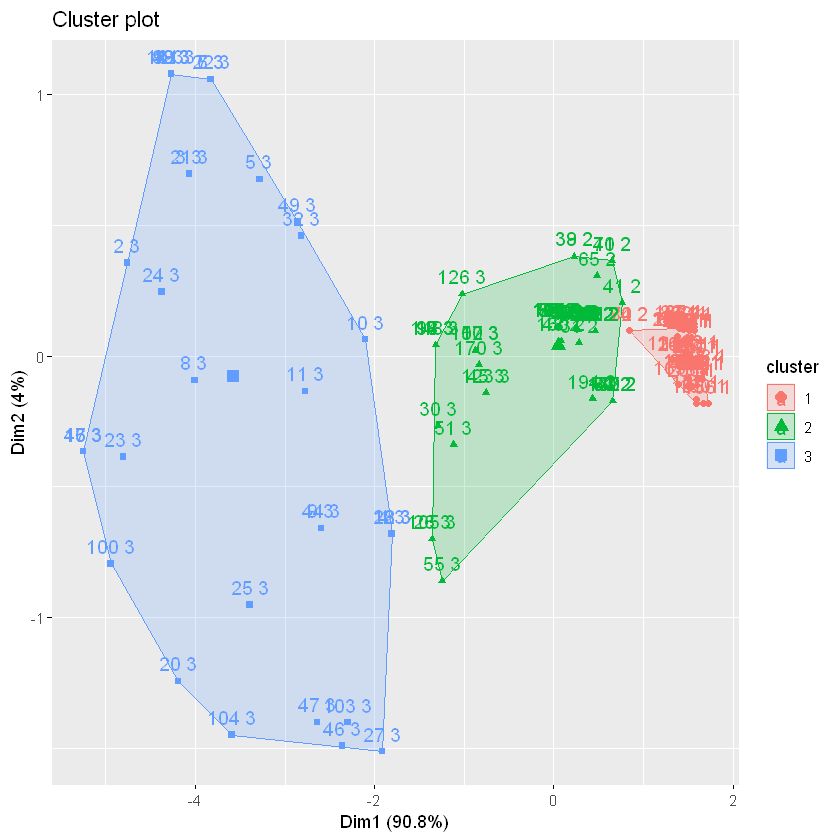

In [55]:
fviz_cluster(kmeans_model, data = phoneData_kmeans[-5])

In [56]:
confusionMatrix(as.factor(phoneData_kmeans$PriceCategory), as.factor(kmeans_model$cluster))

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 85  0  0
         2  3 68  0
         3  0 16 38

Overall Statistics
                                          
               Accuracy : 0.9095          
                 95% CI : (0.8623, 0.9446)
    No Information Rate : 0.419           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8605          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.9659   0.8095   1.0000
Specificity            1.0000   0.9762   0.9070
Pos Pred Value         1.0000   0.9577   0.7037
Neg Pred Value         0.9760   0.8849   1.0000
Prevalence             0.4190   0.4000   0.1810
Detection Rate         0.4048   0.3238   0.1810
Detection Prevalence   0.4048   0.3381   0.2571
Balanced Accuracy      0.9830   0.8929   0.9535